<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget file.weasoft.com/images.zip
!wget file.weasoft.com/summary.csv

In [ ]:
!unzip images.zip

In [2]:
!wget file.weasoft.com/eff_s_1_1010.pt

--2024-01-25 02:01:12--  http://file.weasoft.com/eff_s_1_1010.pt
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121455195 (116M) [application/vnd.snesdev-page-table]
Saving to: ‘eff_s_1_1010.pt’

eff_s_1_1010.pt     100%[===================>] 115.83M  38.3MB/s    in 3.3s    

2024-01-25 02:01:16 (34.9 MB/s) - ‘eff_s_1_1010.pt’ saved [121455195/121455195]



In [1]:
!git clone https://github.com/suanfaxiaohuo/SwinOCSR.git
!pip install focal_loss_torch wandb
!pip3 install deepsmiles yacs tqdm

In [5]:
import sys
import os
import argparse
from tqdm import tqdm
import deepsmiles
from typing import Any, cast, Callable, List, Tuple, Union
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [6]:
import sys
sys.path.append("./SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")
from pre_transformer import Transformer
class FocalLossModelInference:
    """
    Inference Class
    """
    def __init__(self):
        # Load dictionary that maps tokens to integers
        word_map_path = './SwinOCSR/Data/500wan/500wan_shuffle_DeepSMILES_word_map'
        self.word_map = torch.load(word_map_path)
        self.inv_word_map = {v: k for k, v in self.word_map.items()}

        # Define device, load models and weights
        self.dev = "cuda" if torch.cuda.is_available() else "cpu"
        # self.args, config = self.get_inference_config()
        # self.encoder = build_model(config, tag=False)
        self.decoder = self.build_decoder()
        # self.load_checkpoint("./swin_transform_focalloss.pth")
        self.decoder = self.decoder.to(self.dev).eval()
        # self.encoder = self.encoder.to(self.dev).eval()

    def load_checkpoint(self, checkpoint_path):
        """
        Load checkpoint and update encoder and decoder accordingly

        Args:
            checkpoint_path (str): path of checkpoint file
        """
        print(f"=====> {checkpoint_path} <=====")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        # encoder_msg = self.encoder.load_state_dict(checkpoint['encoder'],
        #                                            strict=False)
        decoder_msg = self.decoder.load_state_dict(checkpoint['decoder'],
                                                   strict=False)
        # print(f"Encoder: {encoder_msg}")
        print(f"Decoder: {decoder_msg}")
        del checkpoint
        torch.cuda.empty_cache()

    def build_decoder(self):
        """
        This method builds the Transformer decoder and returns it
        """
        self.decoder_dim = 256  # dimension of decoder RNN
        self.ff_dim = 2048
        self.num_head = 8
        self.dropout = 0.1
        self.encoder_num_layer = 6
        self.decoder_num_layer = 6
        self.max_len = 277
        self.decoder_lr = 5e-4
        self.best_acc = 0.
        return Transformer(dim=self.decoder_dim,
                           ff_dim=self.ff_dim,
                           num_head=self.num_head,
                           encoder_num_layer=self.encoder_num_layer,
                           decoder_num_layer=self.decoder_num_layer,
                           vocab_size=len(self.word_map),
                           max_len=self.max_len,
                           drop_rate=self.dropout,
                           tag=False)
transformer_ = FocalLossModelInference()

In [7]:
import base64
import pandas as pd
import os
# df = pd.read_csv("images_rows.csv")
# os.makedirs("images",exist_ok=1)
# def save_img(id):
#   row = df[df["id"]==id]
#   print(row["image"])
#   with open(f"images/{id}.png", "wb") as fh:
#       fh.write(base64.decodebytes(bytes(row["image"].item().replace("data:image/png;base64,",""), "utf-8")))
# df["id"].apply(save_img)

In [8]:
import sys
sys.path.append("./SwinOCSR/model/Swin-transformer-focalloss")
sys.path.append("./SwinOCSR/model/")

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [55]:
eff = torchvision.models.efficientnet_v2_s(weights='DEFAULT')
mynet = eff.features
class ImageEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.eff = mynet.to(device)
    self.projection = torch.nn.Linear(768,256).to(device)
  def forward(self, images):
    features = self.eff(images)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    return self.projection(features)
class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in, xmask):
    image_feature = self.encoder(image)
    out = self.decoder(text_in, image_feature, x_mask=xmask)
    return out

In [11]:
mod = torch.load("eff_s_1_1010.pt", map_location=device) #it is model not dict

In [12]:
def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch, maxlen

In [13]:
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, image, text_in_, max_len, beam): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
    image_feature = self.encoder(image)
    top_n = list([list(i) for i in torch.tensor(text_in_).repeat(beam,1).detach().cpu().numpy()])
    # print(top_n)
    image_feature = image_feature.repeat_interleave(beam, dim=0)#.repeat_interleave(beam)
    for i in range(max_len):
      if beam == 1:
        padded_text, l = pad_pack(top_n)
        padded_text = padded_text.to(device)
        out = self.decoder(padded_text, image_feature, x_mask=triangle_mask(l).to(device))
        out = out[0,-1,:]
        next = torch.argmax(out)
        top_n[0] += [next.detach().cpu().item()]
        if next == 78:
          return top_n
        continue
      padded_text, l = pad_pack(top_n)
      padded_text = padded_text.to(device)
      out = self.decoder(padded_text, image_feature, x_mask=triangle_mask(l).to(device))
      out = out[:,-1,:]
      next = torch.topk(torch.flatten(out), beam)
      indices2d = np.array(np.unravel_index(next.indices.cpu().numpy(), out.shape)).T
      new_top_n = []
      count = 0
      for j in indices2d:
        beam_number = j[0]
        char = j[1]
        if char == 78:
          count += 1
          new_top_n.append(top_n[beam_number])
        else:
          new_top_n.append(top_n[beam_number] + [char])
      if count == beam:
        return new_top_n
      top_n = new_top_n
    return top_n

In [14]:
gen = SMILESGenerator(mod.encoder, mod.decoder)

In [15]:
def triangle_mask(size):
    mask = 1- np.triu(np.ones((1, size, size)),k=1).astype('uint8')
    mask = torch.autograd.Variable(torch.from_numpy(mask))
    return mask

In [16]:
!wget file.weasoft.com/reverse.map

--2024-01-25 02:01:38--  http://file.weasoft.com/reverse.map
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 875
Saving to: ‘reverse.map’

reverse.map         100%[===================>]     875  --.-KB/s    in 0s      

2024-01-25 02:01:38 (116 MB/s) - ‘reverse.map’ saved [875/875]



In [17]:
reversed_word_map = {}
import json
with open("reverse.map","r") as f:
  reversed_word_map = json.loads(f.read())

In [18]:
from focal_loss.focal_loss import FocalLoss
m = torch.nn.Softmax(dim=-1)
lf = FocalLoss(gamma=2, ignore_index=0)#torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction="none")
def loss_fn(pred, truth):
  pred = m(pred)
  l = lf(pred, truth)
  return l

In [19]:
def mask_acc(pred, truth):
    pred = torch.argmax(pred, -1)
    mask = truth != 0
    match_case = truth == pred
    return torch.sum(mask*match_case)/torch.sum(mask)

In [20]:
BATCH_SIZE = 1

In [21]:
import pandas as pd
molecules_rows = pd.read_csv("summary.csv")

In [ ]:
print("\n".join(list(set([i.split("_")[0] for i in os.listdir("images")]))))

In [95]:
import random
converter = deepsmiles.Converter(rings=True, branches=True)
cids = list(molecules_rows["cid"])
train_cids = [i for i in cids if i!=638066]
val_cids = [i for i in cids if i==638066]
from PIL import ImageOps

def getitem(train=True):
  ti = []
  to = []
  imgs = []
  for i in range(8):
    prefix = random.choice(train_cids if train else val_cids)
    # if (train and name.startswith("638066"))or (not train and not name.startswith("638066")):
    # if train == name.startswith("638066"):
    #   continue
    name = random.choice([i for i in os.listdir("./images") if i.startswith(str(prefix)+"_")])
    img = Image.open(f"images/{name}").convert("RGB")
    if train:
      img = img.rotate(random.choice([0,90,270]), expand=0).resize((400,400))
      if random.random()>0.5:
        img = ImageOps.flip(img)
      if random.random()>0.5:
        img = ImageOps.mirror(img)
      img.crop((random.random()*40,random.random()*40,400-random.random()*40,400-random.random()*40))
    img = np.array(img.resize((400,400)), dtype="float32")
    if train:
      img[:,:,0] *= random.random()*0.2+0.9
      img[:,:,1] *= random.random()*0.2+0.9
      img[:,:,2] *= random.random()*0.2+0.9
    img = torch.tensor(np.array(img)).permute(2, 0, 1).to(torch.float32).to(device)
    if train:
      for _ in range(5):
        x,y = int(random.random()*380),int(random.random()*380)
        img[:,x:x+20, y:y+20] = torch.rand((3,20,20))*200

    # if train:
      # img*=torch.round(torch.tanh(5*torch.rand((3,400,400)))).to(device)
    # print(name)
    # print(converte//r.encode(molecules_rows[molecules_rows["cid"]==int(name.split("_")[0])]["canonicalsmiles"].item()))
    smiles = [transformer_.word_map[i] for i in converter.encode(molecules_rows[molecules_rows["cid"]==int(name.split("_")[0])]["canonicalsmiles"].item())]
    ti.append([77] + smiles)
    to.append(smiles + [78])
    imgs.append(img)
  return torch.stack(imgs), ti, to


In [ ]:
torch.stack([torch.tensor([1,2]) for i in range(10)])

In [ ]:
import pylab
batch = getitem(True)[0].cpu().permute(0, 2, 3, 1).numpy()
for i in batch:
  pylab.imshow(i/255)
  pylab.show()

In [88]:
# print("\n".join([str(i) for i in df["cid"].unique()]))

In [93]:
def val():
  running_loss = 0
  mod.train(False)
  # ids = os.listdir("images")[:10]

  valacc = []
  start_index = i
  image, text_in, text_out = getitem(train=False)

  image = image.to(device)
  text_out = pad_pack(text_out)[0].to(device)
  padded_x = pad_pack(text_in)

  xmask = triangle_mask(padded_x[1]).to(device)
  text_in = padded_x[0].to(device)

  outputs = mod(image, text_in, xmask)
  loss = loss_fn(outputs, text_out)



  running_loss += loss.item()
  valacc.append(mask_acc(outputs.detach(), text_out).item())
  mod.train(True)
  return running_loss, np.mean(valacc)


In [102]:
mod = torch.load("eff_s_1_1010.pt", map_location=device) #it is model not dict

In [79]:
for i in mod.decoder.parameters():
  i.require_grad = False

# for layers in mod.encoder.eff[:4]:
#   for i in layers.parameters():
#     i.require_grad = False

[0.46875]


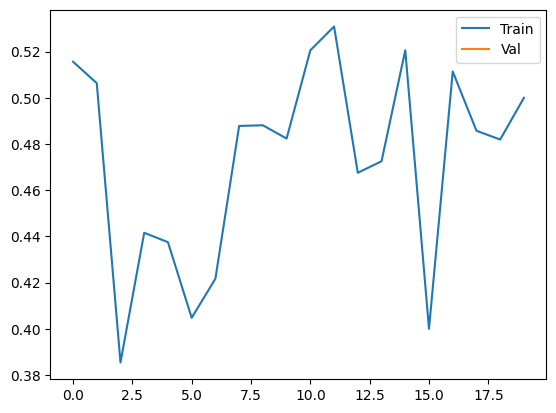

1.86e-05
[0.46875, 0.65625]


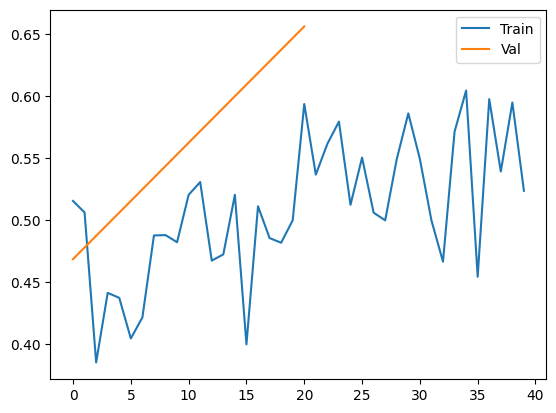

1.7298000000000003e-05
[0.46875, 0.65625, 0.625]


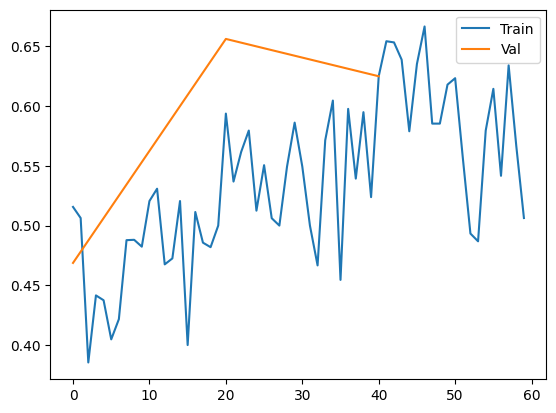

1.6087140000000003e-05
[0.46875, 0.65625, 0.625, 0.609375]


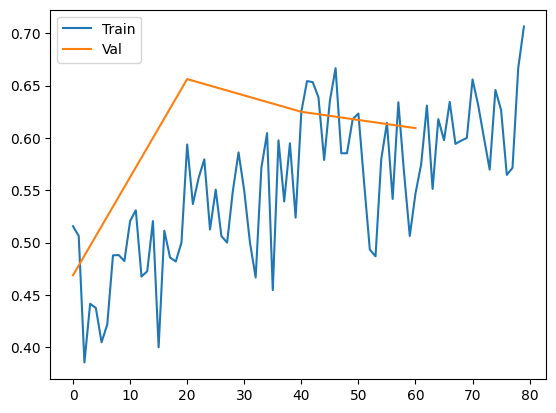

1.4961040200000004e-05
[0.46875, 0.65625, 0.625, 0.609375, 0.71875]


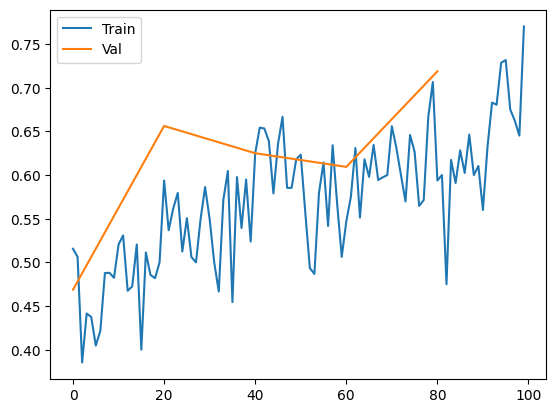

1.3913767386000004e-05
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625]


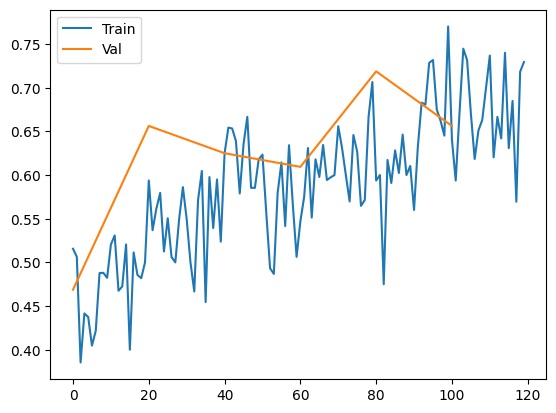

1.2939803668980004e-05
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375]


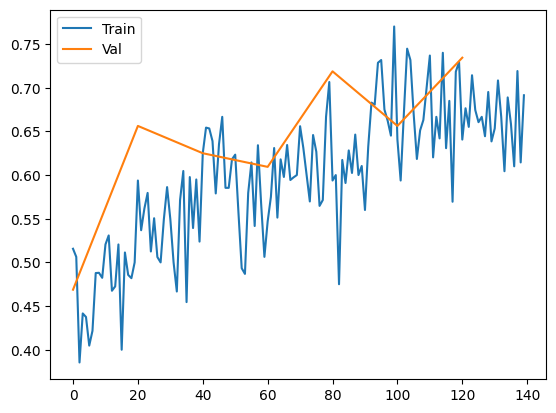

1.2034017412151404e-05
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875]


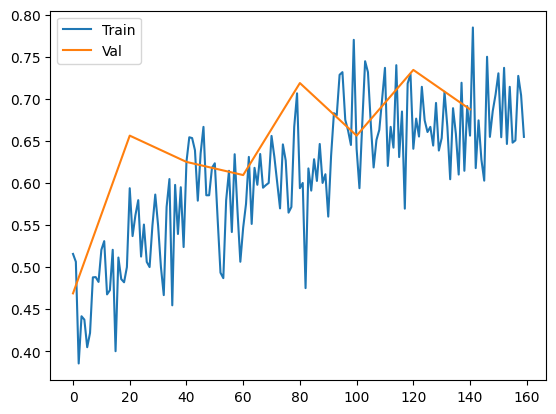

1.1191636193300806e-05
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875]


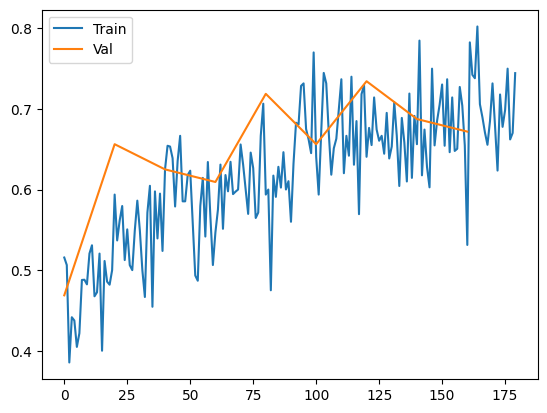

1.040822165976975e-05
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875]


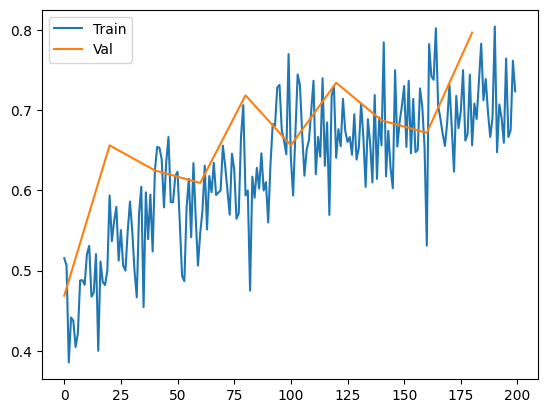

9.679646143585868e-06
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875, 0.765625]


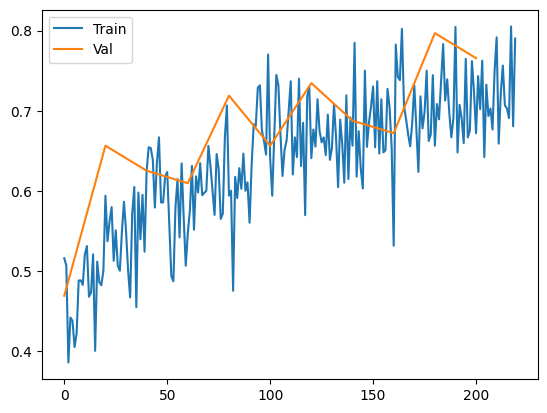

9.002070913534857e-06
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875, 0.765625, 0.765625]


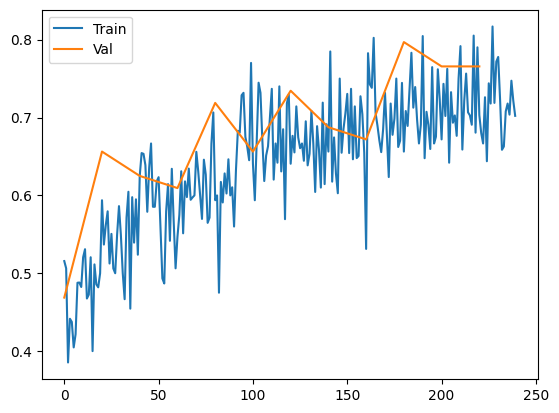

8.371925949587418e-06
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875, 0.765625, 0.765625, 0.75]


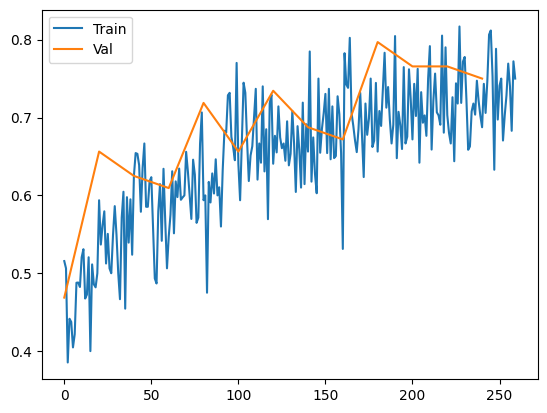

7.7858911331163e-06
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875, 0.765625, 0.765625, 0.75, 0.71875]


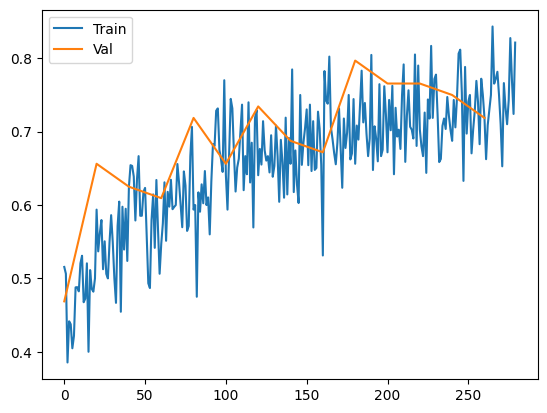

7.240878753798159e-06
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875, 0.765625, 0.765625, 0.75, 0.71875, 0.796875]


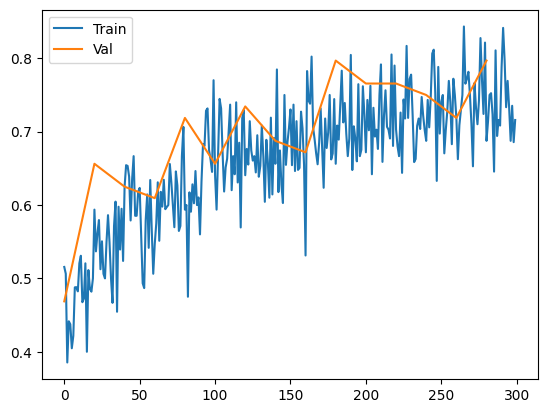

6.7340172410322885e-06
[0.46875, 0.65625, 0.625, 0.609375, 0.71875, 0.65625, 0.734375, 0.6875, 0.671875, 0.796875, 0.765625, 0.765625, 0.75, 0.71875, 0.796875, 0.8125]


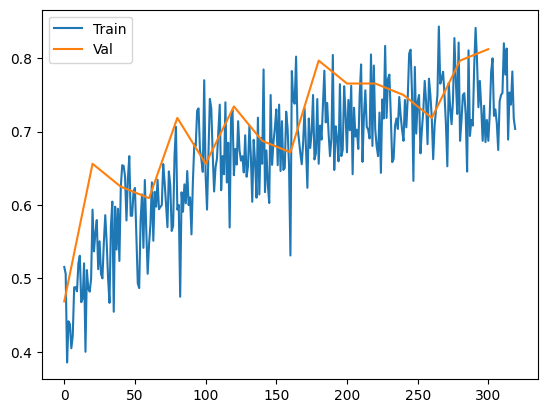

6.262636034160028e-06


In [103]:
losses = []
access = []
val_acc = []
optimizer = torch.optim.AdamW(
   mod.parameters(),
   lr=0.00002)
import pylab
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.93)
running_loss = 0
for epoch in range(16):
  mod.train(True)
  # ids = [i for i in os.listdir("images") if not i.startswith("638066")]
  # ids = os.listdir("images")[10:]
  # np.random.shuffle(ids)
  for i in range(len(os.listdir("images"))//32):
    if i==None:
      continue
    start_index = i
    image, text_in, text_out = getitem(start_index)

    image = image.to(device) #mutli process cannot use cuda so moved here
    # image = torch.permute(image, (0, 3, 1, 2))
    text_out = pad_pack(text_out)[0].to(device)
    padded_x = pad_pack(text_in)

    xmask = triangle_mask(padded_x[1]).to(device)
    text_in = padded_x[0].to(device)

    optimizer.zero_grad()
    outputs = mod(image, text_in, xmask)
    #loss = loss_fn(outputs, text_outi) guaibude yyixiazinamegao
    loss = loss_fn(outputs, text_out)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    losses.append(loss.item())
    access.append(mask_acc(outputs.detach(), text_out))

  val_acc.append(val()[1])
  print(val_acc)
  scheduler.step()
  pylab.plot([i.item() for i in access], label="Train")
  pylab.plot(np.arange(len(val_acc))*(len(access)/len(val_acc)),val_acc,label="Val")
  pylab.legend()
  pylab.show()
  print(optimizer.param_groups[0]["lr"])

In [104]:
#This time very well how???????
torch.seed()

14312186144326183695

In [31]:
res = np.array([i.item() for i in access[350:]])

In [32]:
np.sum(res==1)/len(res)

0.006535947712418301

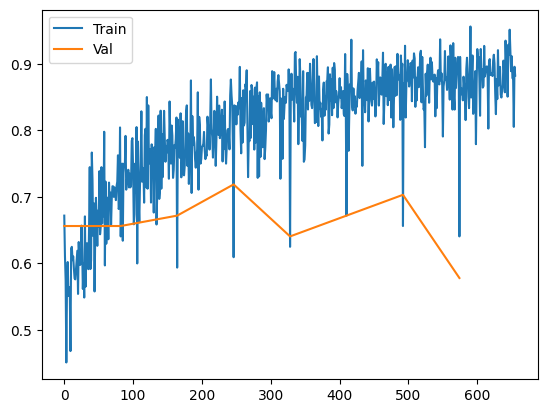

In [65]:
pylab.plot([i.item() for i in access], label="Train")
pylab.plot(np.arange(len(val_acc))*(len(access)/len(val_acc)),val_acc,label="Val")
pylab.legend()

In [34]:
image.requires_grad_()
outputs = mod(image, text_in, xmask)
loss = loss_fn(outputs, text_out)
loss.backward()

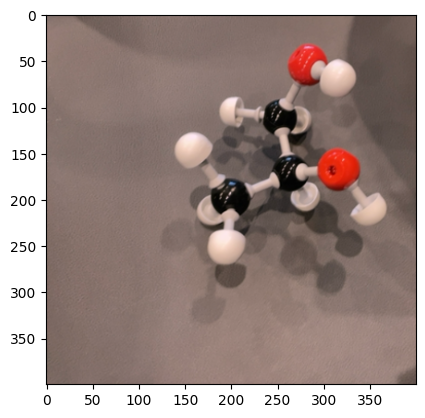

In [35]:
img = image[0].permute(1,2,0).detach().cpu()
pylab.imshow(img/torch.max(img))

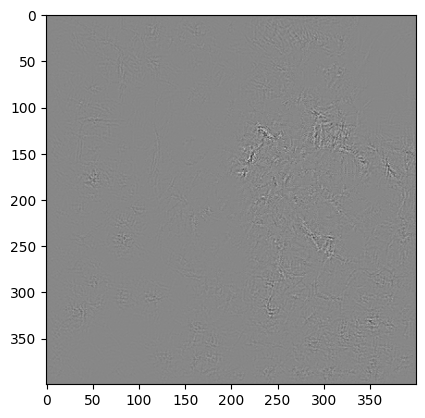

In [36]:
ans = image.grad[0].permute(1,2,0).cpu()
ans = (ans-torch.mean(ans))/torch.std(ans)
pylab.imshow(torch.sum(((ans)), dim=-1), cmap="gray")